<b>This notebook is to document the broad range optimization of a keras sequential model for predicting solubility.
Documenting the process of choosing network topology, chemical fingerprints and their parameters.</b>

I will be using 2500 as the bit size thanks to @delton137 from his great, simple post: http://moreisdifferent.com/2017/9/21/DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning-for-solubility-prediction/. He showed that for all fingerprints there was an increase in performance until convergence around 2000 bit size fingerprint. 

for more information on fingerprinting here are some links <a href=http://www.daylight.com/dayhtml/doc/theory/theory.finger.html>6. Fingerprints - Screening and Similarity
from daylight</a>
and <a href=http://www.daylight.com/dayhtml/doc/theory/theory.finger.html> chemAxon docs on fingerprinting</a>

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from rdkit import Chem
from keras.layers.core import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D, Dropout
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor
from rdkit import Chem, Avalon 
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit import DataStructs
from rdkit.Chem import AllChem
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import kernel_ridge
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from rdkit import Chem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import AllChem
from sklearn.model_selection import GridSearchCV
from rdkit.Chem.Pharm2D import Generate 


#set a seed for reproducibility sakes
seed = 13
np.random.seed(seed)
#from rdkit.Chem.Pharm2D import SigFactory
#from rdkit.Chem.EState import Fingerprinter
#from rdkit.Chem import Descriptors
#from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.EState import Fingerprinter 
#Lets read the Sol.csv file that contains the SMILES and solubility values for each
df = pd.read_csv('./H_SolubilityData.csv')
preX = df['SMILES']
preY = df['VALUE']


fpDic = {}
typeOfFp = ['Morgan','RDkit','Avalon','AtomPair']


C:\Users\Brandon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
smile = "[nH](c(c(c1cccc2)ccc3)c3)c12"
mol_ = Chem.MolFromSmiles(smile)
fp_ = (AllChem.rdmolops.RDKFingerprint(mol_,fpSize=1000))


In [112]:
#this function gets fp from smiles and optionally the descriptors if boolean is true
def get_fp(smiles_,values_,bits_,boolean_=False):
    fpArray_=[]
    valsToReturn=[]
    for i in range(len(smiles_)):
        mol = Chem.MolFromSmiles(smiles_[i])
        if mol is None:
            continue
        else:
            fp = (AllChem.rdmolops.RDKFingerprint(mol,fpSize=bits_))
            if(boolean_== True):
                fp = list(fp)
                molWt = Descriptors.ExactMolWt(mol)
                logP = Chem.Crippen.MolLogP(mol)
                heavy_atom_count = Lipinski.HeavyAtomCount(mol)
                h_donors = Lipinski.NumHDonors(mol)
                h_acceptors = Lipinski.NumHAcceptors(mol)
                aromatic_rings = Lipinski.NumAromaticRings(mol)
                NOCount = Lipinski.NOCount(mol)
                NHOHCount = Lipinski.NHOHCount(mol)
                fp.extend([molWt,logP,heavy_atom_count,
                              h_donors,h_acceptors,aromatic_rings,NOCount,NHOHCount])
            
            fpArray_.append(fp)
            valsToReturn.append(values_[i])
    return fpArray_, valsToReturn   

In [110]:
#lets make a dunction that i will create a model with input_dim of the parameter length
def baseline_model():
    model = Sequential()
    model.add(Dense(len(X128[0]),input_dim=len(X128[0]),activation='relu',kernel_initializer='normal'))
    model.add(Dense(128,activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(optimizer='adam', loss='mse')
    return model



In [113]:
X2048,Y2048 = get_fp(preX,preY,2048)
X2048True,Y2048True = get_fp(preX,preY,150,True)


In [5]:
#make the training data
X128,Y128 = get_fp(preX,preY,150)
X200,Y200 = get_fp(preX,preY,200,True)
X256,Y256 = get_fp(preX,preY,256,True)


In [6]:
model = baseline_model()
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5)

kfold = KFold(n_splits=10,shuffle=True, random_state=seed)
results = cross_val_score(estimator, np.array(X128[:1000]),np.array(Y128[:1000]), cv=kfold)
print(f"basic model: {results.mean()} {results.std()} MSE")

Epoch 1/100
900/900 [==============================] - 0s 513us/step - loss: 2.9675
Epoch 2/100
900/900 [==============================] - 0s 271us/step - loss: 1.8261
Epoch 3/100
900/900 [==============================] - 0s 265us/step - loss: 1.4894
Epoch 4/100
900/900 [==============================] - 0s 279us/step - loss: 1.3825
Epoch 5/100
900/900 [==============================] - 0s 245us/step - loss: 1.3015
Epoch 6/100
900/900 [==============================] - 0s 213us/step - loss: 1.2205
Epoch 7/100
900/900 [==============================] - 0s 215us/step - loss: 1.1477
Epoch 8/100
900/900 [==============================] - 0s 214us/step - loss: 1.0105
Epoch 9/100
900/900 [==============================] - 0s 217us/step - loss: 1.1476
Epoch 10/100
900/900 [==============================] - 0s 221us/step - loss: 1.0486
Epoch 11/100
900/900 [==============================] - 0s 215us/step - loss: 0.9722
Epoch 12/100
900/900 [==============================] - 0s 219us/step - lo

Epoch 93/100
900/900 [==============================] - 0s 278us/step - loss: 0.5192
Epoch 94/100
900/900 [==============================] - 0s 287us/step - loss: 0.4657
Epoch 95/100
900/900 [==============================] - 0s 271us/step - loss: 0.4154
Epoch 96/100
900/900 [==============================] - 0s 275us/step - loss: 0.4979
Epoch 97/100
900/900 [==============================] - 0s 277us/step - loss: 0.4653
Epoch 98/100
900/900 [==============================] - 0s 273us/step - loss: 0.4237
Epoch 99/100
900/900 [==============================] - 0s 271us/step - loss: 0.4320
Epoch 100/100
100/100 [==============================] - 0s 588us/step
Epoch 1/100
900/900 [==============================] - 1s 716us/step - loss: 3.1550
Epoch 2/100
900/900 [==============================] - 0s 271us/step - loss: 1.6890
Epoch 3/100
900/900 [==============================] - 0s 278us/step - loss: 1.5459
Epoch 4/100
900/900 [==============================] - 0s 274us/step - loss: 1.453

Epoch 84/100
900/900 [==============================] - 0s 259us/step - loss: 0.5148
Epoch 85/100
900/900 [==============================] - 0s 266us/step - loss: 0.5554
Epoch 86/100
900/900 [==============================] - 0s 260us/step - loss: 0.5306
Epoch 87/100
900/900 [==============================] - 0s 265us/step - loss: 0.5358
Epoch 88/100
900/900 [==============================] - 0s 260us/step - loss: 0.5447
Epoch 89/100
900/900 [==============================] - 0s 262us/step - loss: 0.4831
Epoch 90/100
900/900 [==============================] - 0s 263us/step - loss: 0.4785
Epoch 91/100
900/900 [==============================] - 0s 262us/step - loss: 0.5559
Epoch 92/100
900/900 [==============================] - 0s 262us/step - loss: 0.4807
Epoch 93/100
900/900 [==============================] - 0s 260us/step - loss: 0.4822
Epoch 94/100
900/900 [==============================] - 0s 260us/step - loss: 0.5584
Epoch 95/100
900/900 [==============================] - 0s 264us/

Epoch 75/100
900/900 [==============================] - 0s 452us/step - loss: 0.5568
Epoch 76/100
900/900 [==============================] - 0s 434us/step - loss: 0.5129
Epoch 77/100
900/900 [==============================] - 0s 346us/step - loss: 0.5329
Epoch 78/100
900/900 [==============================] - 0s 386us/step - loss: 0.5298
Epoch 79/100
900/900 [==============================] - 0s 351us/step - loss: 0.4780
Epoch 80/100
900/900 [==============================] - 0s 367us/step - loss: 0.4976
Epoch 81/100
900/900 [==============================] - 0s 417us/step - loss: 0.4639
Epoch 82/100
900/900 [==============================] - 0s 327us/step - loss: 0.4835
Epoch 83/100
900/900 [==============================] - 0s 328us/step - loss: 0.5120
Epoch 84/100
900/900 [==============================] - 0s 373us/step - loss: 0.4881
Epoch 85/100
900/900 [==============================] - 0s 308us/step - loss: 0.4895
Epoch 86/100
900/900 [==============================] - 0s 306us/

Epoch 66/100
900/900 [==============================] - 0s 287us/step - loss: 0.5638
Epoch 67/100
900/900 [==============================] - 0s 285us/step - loss: 0.6515
Epoch 68/100
900/900 [==============================] - 0s 283us/step - loss: 0.5386
Epoch 69/100
900/900 [==============================] - 0s 280us/step - loss: 0.5732
Epoch 70/100
900/900 [==============================] - 0s 274us/step - loss: 0.5494
Epoch 71/100
900/900 [==============================] - 0s 291us/step - loss: 0.5305
Epoch 72/100
900/900 [==============================] - 0s 277us/step - loss: 0.5931
Epoch 73/100
900/900 [==============================] - 0s 271us/step - loss: 0.5860
Epoch 74/100
900/900 [==============================] - 0s 276us/step - loss: 0.5226
Epoch 75/100
900/900 [==============================] - 0s 276us/step - loss: 0.5340
Epoch 76/100
900/900 [==============================] - 0s 281us/step - loss: 0.5264
Epoch 77/100
900/900 [==============================] - 0s 273us/

Epoch 57/100
900/900 [==============================] - 0s 262us/step - loss: 0.5499
Epoch 58/100
900/900 [==============================] - 0s 266us/step - loss: 0.6027
Epoch 59/100
900/900 [==============================] - 0s 262us/step - loss: 0.5775
Epoch 60/100
900/900 [==============================] - 0s 267us/step - loss: 0.6168
Epoch 61/100
900/900 [==============================] - 0s 268us/step - loss: 0.6517
Epoch 62/100
900/900 [==============================] - 0s 266us/step - loss: 0.5627
Epoch 63/100
900/900 [==============================] - 0s 271us/step - loss: 0.5645
Epoch 64/100
900/900 [==============================] - 0s 263us/step - loss: 0.5486
Epoch 65/100
900/900 [==============================] - 0s 275us/step - loss: 0.5650
Epoch 66/100
900/900 [==============================] - 0s 271us/step - loss: 0.5932
Epoch 67/100
900/900 [==============================] - 0s 260us/step - loss: 0.5385
Epoch 68/100
900/900 [==============================] - 0s 269us/

In [9]:
#pipeline will be a scaler then the model data->(scale -> model ) -> output
steps =[]
steps.append(('standardize', StandardScaler()))
steps.append(('KNN',KerasRegressor(build_fn=baseline_model,epochs=100,batch_size=5,verbose=0)))
pipeline = Pipeline(steps)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, np.array(X128[:1000]),np.array(Y128[:1000]), cv=kfold)
print(f"basic model standardized: {results.mean()} {results.std()} MSE")

C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was

basic model standardized: -2.156321394406259 1.9415479578040291 MSE


In [10]:
#we will test a 1 hidden layer larger model here
def larger_model():
    model = Sequential()
    model.add(Dense(len(X128[0]), input_dim=len(X128[0]), kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=larger_model, epochs=100, batch_size=5)

kfold = KFold(n_splits=10,shuffle=True, random_state=seed)
results = cross_val_score(estimator, np.array(X128[:1000]),np.array(Y128[:1000]), cv=kfold)
print(f"basic model: {results.mean()} {results.std()} MSE")

Epoch 1/100
900/900 [==============================] - 1s 1ms/step - loss: 3.5607
Epoch 2/100
900/900 [==============================] - 0s 333us/step - loss: 1.9898
Epoch 3/100
900/900 [==============================] - 0s 320us/step - loss: 1.6543
Epoch 4/100
900/900 [==============================] - 0s 326us/step - loss: 1.5054
Epoch 5/100
900/900 [==============================] - 0s 367us/step - loss: 1.4785
Epoch 6/100
900/900 [==============================] - 0s 358us/step - loss: 1.3464
Epoch 7/100
900/900 [==============================] - 0s 316us/step - loss: 1.2289
Epoch 8/100
900/900 [==============================] - 0s 310us/step - loss: 1.2167
Epoch 9/100
900/900 [==============================] - 0s 332us/step - loss: 1.1276
Epoch 10/100
900/900 [==============================] - 0s 383us/step - loss: 1.1055
Epoch 11/100
900/900 [==============================] - 0s 329us/step - loss: 1.0456
Epoch 12/100
900/900 [==============================] - 1s 583us/step - loss

900/900 [==============================] - 0s 336us/step - loss: 0.4526
Epoch 94/100
900/900 [==============================] - 0s 337us/step - loss: 0.4440
Epoch 95/100
900/900 [==============================] - 0s 349us/step - loss: 0.4211
Epoch 96/100
900/900 [==============================] - 0s 342us/step - loss: 0.4116
Epoch 97/100
900/900 [==============================] - 0s 344us/step - loss: 0.4387
Epoch 98/100
900/900 [==============================] - 0s 346us/step - loss: 0.4344
Epoch 99/100
900/900 [==============================] - 0s 340us/step - loss: 0.4278
Epoch 100/100
100/100 [==============================] - 0s 4ms/step
Epoch 1/100
900/900 [==============================] - 1s 1ms/step - loss: 3.6262
Epoch 2/100
900/900 [==============================] - 0s 351us/step - loss: 2.0805
Epoch 3/100
900/900 [==============================] - 0s 351us/step - loss: 1.6232
Epoch 4/100
900/900 [==============================] - 0s 352us/step - loss: 1.4172
Epoch 5/100
900

900/900 [==============================] - 0s 351us/step - loss: 0.5051
Epoch 85/100
900/900 [==============================] - 0s 362us/step - loss: 0.5613
Epoch 86/100
900/900 [==============================] - 0s 382us/step - loss: 0.5101
Epoch 87/100
900/900 [==============================] - 0s 367us/step - loss: 0.5030
Epoch 88/100
900/900 [==============================] - 0s 363us/step - loss: 0.5753
Epoch 89/100
900/900 [==============================] - 0s 357us/step - loss: 0.5213
Epoch 90/100
900/900 [==============================] - 0s 357us/step - loss: 0.5017
Epoch 91/100
900/900 [==============================] - 0s 381us/step - loss: 0.5188
Epoch 92/100
900/900 [==============================] - 0s 366us/step - loss: 0.5810
Epoch 93/100
900/900 [==============================] - 0s 369us/step - loss: 0.5639
Epoch 94/100
900/900 [==============================] - 0s 396us/step - loss: 0.5407
Epoch 95/100
900/900 [==============================] - 0s 375us/step - loss: 

900/900 [==============================] - 0s 344us/step - loss: 0.5106
Epoch 81/100
900/900 [==============================] - 0s 355us/step - loss: 0.5468
Epoch 82/100
900/900 [==============================] - 0s 369us/step - loss: 0.5427
Epoch 83/100
900/900 [==============================] - 0s 343us/step - loss: 0.4658
Epoch 84/100
900/900 [==============================] - 0s 346us/step - loss: 0.5223
Epoch 85/100
900/900 [==============================] - 0s 355us/step - loss: 0.5290
Epoch 86/100
900/900 [==============================] - 0s 365us/step - loss: 0.4750
Epoch 87/100
900/900 [==============================] - 0s 344us/step - loss: 0.4983
Epoch 88/100
900/900 [==============================] - 0s 351us/step - loss: 0.4731
Epoch 89/100
900/900 [==============================] - 0s 350us/step - loss: 0.4949
Epoch 90/100
900/900 [==============================] - 0s 339us/step - loss: 0.4976
Epoch 91/100
900/900 [==============================] - 0s 353us/step - loss: 

900/900 [==============================] - 0s 397us/step - loss: 0.4897
Epoch 77/100
900/900 [==============================] - 0s 358us/step - loss: 0.4908
Epoch 78/100
900/900 [==============================] - 0s 378us/step - loss: 0.5281
Epoch 79/100
900/900 [==============================] - 0s 373us/step - loss: 0.5290
Epoch 80/100
900/900 [==============================] - 0s 356us/step - loss: 0.5132 0s - loss: 0.514
Epoch 81/100
900/900 [==============================] - 0s 349us/step - loss: 0.5119
Epoch 82/100
900/900 [==============================] - 0s 351us/step - loss: 0.4739
Epoch 83/100
900/900 [==============================] - 0s 352us/step - loss: 0.5099
Epoch 84/100
900/900 [==============================] - 0s 380us/step - loss: 0.4931
Epoch 85/100
900/900 [==============================] - 0s 381us/step - loss: 0.5146
Epoch 86/100
900/900 [==============================] - 0s 402us/step - loss: 0.4933
Epoch 87/100
900/900 [==============================] - 0s 38

900/900 [==============================] - 0s 361us/step - loss: 0.5815
Epoch 67/100
900/900 [==============================] - 0s 367us/step - loss: 0.5593
Epoch 68/100
900/900 [==============================] - 0s 380us/step - loss: 0.5347
Epoch 69/100
900/900 [==============================] - 0s 364us/step - loss: 0.5637
Epoch 70/100
900/900 [==============================] - 0s 359us/step - loss: 0.5552
Epoch 71/100
900/900 [==============================] - 0s 356us/step - loss: 0.5119
Epoch 72/100
900/900 [==============================] - 0s 366us/step - loss: 0.5589
Epoch 73/100
900/900 [==============================] - 0s 499us/step - loss: 0.5184
Epoch 74/100
900/900 [==============================] - 1s 572us/step - loss: 0.4987
Epoch 75/100
900/900 [==============================] - 0s 523us/step - loss: 0.5415
Epoch 76/100
900/900 [==============================] - 0s 490us/step - loss: 0.5141
Epoch 77/100
900/900 [==============================] - 0s 493us/step - loss: 

900/900 [==============================] - 0s 504us/step - loss: 0.5208
Epoch 63/100
900/900 [==============================] - 0s 424us/step - loss: 0.5738
Epoch 64/100
900/900 [==============================] - 0s 382us/step - loss: 0.4992
Epoch 65/100
900/900 [==============================] - 0s 379us/step - loss: 0.5323
Epoch 66/100
900/900 [==============================] - 0s 378us/step - loss: 0.5519
Epoch 67/100
900/900 [==============================] - 0s 379us/step - loss: 0.4769
Epoch 68/100
900/900 [==============================] - 0s 419us/step - loss: 0.4817
Epoch 69/100
900/900 [==============================] - 0s 483us/step - loss: 0.5103
Epoch 70/100
900/900 [==============================] - 0s 413us/step - loss: 0.4954
Epoch 71/100
900/900 [==============================] - 0s 408us/step - loss: 0.5268
Epoch 72/100
900/900 [==============================] - 0s 398us/step - loss: 0.5076
Epoch 73/100
900/900 [==============================] - 0s 380us/step - loss: 

900/900 [==============================] - 0s 393us/step - loss: 0.5600
Epoch 59/100
900/900 [==============================] - 0s 388us/step - loss: 0.5401
Epoch 60/100
900/900 [==============================] - 0s 398us/step - loss: 0.5912
Epoch 61/100
900/900 [==============================] - 0s 389us/step - loss: 0.5458
Epoch 62/100
900/900 [==============================] - 0s 389us/step - loss: 0.5882
Epoch 63/100
900/900 [==============================] - 0s 395us/step - loss: 0.5192
Epoch 64/100
900/900 [==============================] - 0s 396us/step - loss: 0.5034
Epoch 65/100
900/900 [==============================] - 0s 386us/step - loss: 0.5357
Epoch 66/100
900/900 [==============================] - 0s 396us/step - loss: 0.4846
Epoch 67/100
900/900 [==============================] - 0s 392us/step - loss: 0.5802
Epoch 68/100
900/900 [==============================] - 0s 390us/step - loss: 0.5267
Epoch 69/100
900/900 [==============================] - 0s 392us/step - loss: 

In [11]:
#investigate a wider model, it will have more nodes in the input layer but only one hidden layer
def wider_longer_model():
    model = Sequential()
    model.add(Dense((len(X128[0])+8), input_dim=len(X128[0]), kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
    
estimator = KerasRegressor(build_fn=wider_longer_model, epochs=100, batch_size=5)

kfold = KFold(n_splits=10,shuffle=True, random_state=seed)
results = cross_val_score(estimator, np.array(X128[:1000]),np.array(Y128[:1000]), cv=kfold)
print(f"basic wider_longer_model: {results.mean()} {results.std()} MSE")

Epoch 1/100
900/900 [==============================] - 1s 2ms/step - loss: 4.1467
Epoch 2/100
900/900 [==============================] - 0s 397us/step - loss: 2.2858
Epoch 3/100
900/900 [==============================] - 0s 404us/step - loss: 1.6707
Epoch 4/100
900/900 [==============================] - 0s 400us/step - loss: 1.5194
Epoch 5/100
900/900 [==============================] - 0s 398us/step - loss: 1.4517
Epoch 6/100
900/900 [==============================] - 0s 399us/step - loss: 1.4140
Epoch 7/100
900/900 [==============================] - 0s 403us/step - loss: 1.3051
Epoch 8/100
900/900 [==============================] - 0s 411us/step - loss: 1.2740
Epoch 9/100
900/900 [==============================] - 0s 398us/step - loss: 1.1352
Epoch 10/100
900/900 [==============================] - 0s 412us/step - loss: 1.0728
Epoch 11/100
900/900 [==============================] - 0s 400us/step - loss: 1.0947
Epoch 12/100
900/900 [==============================] - 0s 398us/step - loss

900/900 [==============================] - 0s 411us/step - loss: 0.4535
Epoch 94/100
900/900 [==============================] - 0s 399us/step - loss: 0.4449
Epoch 95/100
900/900 [==============================] - 0s 398us/step - loss: 0.4244
Epoch 96/100
900/900 [==============================] - 0s 410us/step - loss: 0.4601
Epoch 97/100
900/900 [==============================] - 0s 402us/step - loss: 0.4599
Epoch 98/100
900/900 [==============================] - 0s 406us/step - loss: 0.4850
Epoch 99/100
900/900 [==============================] - 0s 403us/step - loss: 0.4640
Epoch 100/100
100/100 [==============================] - 0s 5ms/step
Epoch 1/100
900/900 [==============================] - 1s 2ms/step - loss: 3.9104
Epoch 2/100
900/900 [==============================] - 0s 410us/step - loss: 2.1471
Epoch 3/100
900/900 [==============================] - 0s 422us/step - loss: 1.7619
Epoch 4/100
900/900 [==============================] - 0s 414us/step - loss: 1.5563
Epoch 5/100
900

900/900 [==============================] - 0s 419us/step - loss: 0.5684
Epoch 85/100
900/900 [==============================] - 0s 422us/step - loss: 0.5650
Epoch 86/100
900/900 [==============================] - 0s 420us/step - loss: 0.5211
Epoch 87/100
900/900 [==============================] - 0s 420us/step - loss: 0.5092
Epoch 88/100
900/900 [==============================] - 0s 416us/step - loss: 0.5137
Epoch 89/100
900/900 [==============================] - 0s 420us/step - loss: 0.5049
Epoch 90/100
900/900 [==============================] - 0s 418us/step - loss: 0.5682
Epoch 91/100
900/900 [==============================] - 0s 421us/step - loss: 0.5718
Epoch 92/100
900/900 [==============================] - 0s 417us/step - loss: 0.5120
Epoch 93/100
900/900 [==============================] - 0s 429us/step - loss: 0.4988
Epoch 94/100
900/900 [==============================] - 0s 414us/step - loss: 0.5286
Epoch 95/100
900/900 [==============================] - 0s 411us/step - loss: 

900/900 [==============================] - 0s 421us/step - loss: 0.5474
Epoch 81/100
900/900 [==============================] - 0s 428us/step - loss: 0.4953
Epoch 82/100
900/900 [==============================] - 0s 421us/step - loss: 0.4724
Epoch 83/100
900/900 [==============================] - 0s 421us/step - loss: 0.5017
Epoch 84/100
900/900 [==============================] - 0s 421us/step - loss: 0.4780
Epoch 85/100
900/900 [==============================] - 0s 429us/step - loss: 0.4682
Epoch 86/100
900/900 [==============================] - 0s 419us/step - loss: 0.5133
Epoch 87/100
900/900 [==============================] - 0s 422us/step - loss: 0.4599
Epoch 88/100
900/900 [==============================] - 0s 417us/step - loss: 0.4501
Epoch 89/100
900/900 [==============================] - 0s 414us/step - loss: 0.4736
Epoch 90/100
900/900 [==============================] - 0s 422us/step - loss: 0.5000
Epoch 91/100
900/900 [==============================] - 0s 416us/step - loss: 

900/900 [==============================] - 0s 427us/step - loss: 0.5169
Epoch 77/100
900/900 [==============================] - 0s 424us/step - loss: 0.4738
Epoch 78/100
900/900 [==============================] - 0s 432us/step - loss: 0.4596
Epoch 79/100
900/900 [==============================] - 0s 427us/step - loss: 0.4837
Epoch 80/100
900/900 [==============================] - 0s 431us/step - loss: 0.5139
Epoch 81/100
900/900 [==============================] - 0s 434us/step - loss: 0.4843
Epoch 82/100
900/900 [==============================] - 0s 428us/step - loss: 0.4964
Epoch 83/100
900/900 [==============================] - 0s 422us/step - loss: 0.4833
Epoch 84/100
900/900 [==============================] - 0s 426us/step - loss: 0.5507
Epoch 85/100
900/900 [==============================] - 0s 429us/step - loss: 0.4784
Epoch 86/100
900/900 [==============================] - 0s 426us/step - loss: 0.4880
Epoch 87/100
900/900 [==============================] - 0s 428us/step - loss: 

900/900 [==============================] - 0s 428us/step - loss: 0.5145
Epoch 73/100
900/900 [==============================] - 0s 431us/step - loss: 0.5386
Epoch 74/100
900/900 [==============================] - 0s 440us/step - loss: 0.4766
Epoch 75/100
900/900 [==============================] - 0s 429us/step - loss: 0.5171
Epoch 76/100
900/900 [==============================] - 0s 432us/step - loss: 0.4932
Epoch 77/100
900/900 [==============================] - 0s 439us/step - loss: 0.5300
Epoch 78/100
900/900 [==============================] - 0s 429us/step - loss: 0.5101
Epoch 79/100
900/900 [==============================] - 0s 432us/step - loss: 0.4855
Epoch 80/100
900/900 [==============================] - 0s 433us/step - loss: 0.4838
Epoch 81/100
900/900 [==============================] - 0s 429us/step - loss: 0.5126
Epoch 82/100
900/900 [==============================] - 0s 440us/step - loss: 0.5077
Epoch 83/100
900/900 [==============================] - 0s 427us/step - loss: 

900/900 [==============================] - 0s 467us/step - loss: 0.5142
Epoch 63/100
900/900 [==============================] - 0s 443us/step - loss: 0.5107
Epoch 64/100
900/900 [==============================] - 0s 444us/step - loss: 0.5163
Epoch 65/100
900/900 [==============================] - 0s 452us/step - loss: 0.5020
Epoch 66/100
900/900 [==============================] - 0s 449us/step - loss: 0.5319
Epoch 67/100
900/900 [==============================] - 0s 447us/step - loss: 0.5288
Epoch 68/100
900/900 [==============================] - 0s 445us/step - loss: 0.4688
Epoch 69/100
900/900 [==============================] - 0s 489us/step - loss: 0.5394
Epoch 70/100
900/900 [==============================] - 0s 458us/step - loss: 0.5336
Epoch 71/100
900/900 [==============================] - 0s 442us/step - loss: 0.4879
Epoch 72/100
900/900 [==============================] - 0s 451us/step - loss: 0.4654
Epoch 73/100
900/900 [==============================] - 0s 451us/step - loss: 

900/900 [==============================] - 0s 442us/step - loss: 0.5733
Epoch 59/100
900/900 [==============================] - 0s 451us/step - loss: 0.5624
Epoch 60/100
900/900 [==============================] - 0s 458us/step - loss: 0.5788
Epoch 61/100
900/900 [==============================] - 0s 452us/step - loss: 0.5823
Epoch 62/100
900/900 [==============================] - 0s 448us/step - loss: 0.5433
Epoch 63/100
900/900 [==============================] - 0s 447us/step - loss: 0.5325
Epoch 64/100
900/900 [==============================] - 0s 445us/step - loss: 0.5603
Epoch 65/100
900/900 [==============================] - 0s 446us/step - loss: 0.5166
Epoch 66/100
900/900 [==============================] - 0s 445us/step - loss: 0.5149
Epoch 67/100
900/900 [==============================] - 0s 451us/step - loss: 0.5458
Epoch 68/100
900/900 [==============================] - 0s 446us/step - loss: 0.5233
Epoch 69/100
900/900 [==============================] - 0s 445us/step - loss: 

In [12]:
def wider_model():
    model = Sequential()
    model.add(Dense((len(X128[0])+8), input_dim=len(X128[0]), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
    
estimator = KerasRegressor(build_fn=wider_model, epochs=100, batch_size=5)

kfold = KFold(n_splits=10,shuffle=True, random_state=seed)
results = cross_val_score(estimator, np.array(X128[:1000]),np.array(Y128[:1000]), cv=kfold)
print(f"wider model: {results.mean()} {results.std()} MSE")

Epoch 1/100
900/900 [==============================] - 2s 2ms/step - loss: 3.1999
Epoch 2/100
900/900 [==============================] - 0s 407us/step - loss: 1.8474
Epoch 3/100
900/900 [==============================] - 0s 383us/step - loss: 1.6956
Epoch 4/100
900/900 [==============================] - 0s 401us/step - loss: 1.4292
Epoch 5/100
900/900 [==============================] - 0s 409us/step - loss: 1.2999
Epoch 6/100
900/900 [==============================] - 0s 361us/step - loss: 1.2707
Epoch 7/100
900/900 [==============================] - 0s 370us/step - loss: 1.2172
Epoch 8/100
900/900 [==============================] - 0s 380us/step - loss: 1.2120
Epoch 9/100
900/900 [==============================] - 0s 370us/step - loss: 1.1310
Epoch 10/100
900/900 [==============================] - 0s 377us/step - loss: 1.0459
Epoch 11/100
900/900 [==============================] - 0s 380us/step - loss: 0.9706
Epoch 12/100
900/900 [==============================] - 0s 380us/step - loss

900/900 [==============================] - 1s 692us/step - loss: 0.4918
Epoch 94/100
900/900 [==============================] - 1s 695us/step - loss: 0.4415
Epoch 95/100
900/900 [==============================] - 1s 713us/step - loss: 0.4453
Epoch 96/100
900/900 [==============================] - 1s 797us/step - loss: 0.4113
Epoch 97/100
900/900 [==============================] - 1s 710us/step - loss: 0.4454
Epoch 98/100
900/900 [==============================] - 1s 625us/step - loss: 0.4270
Epoch 99/100
900/900 [==============================] - 1s 613us/step - loss: 0.3994
Epoch 100/100
100/100 [==============================] - 1s 6ms/step
Epoch 1/100
900/900 [==============================] - 2s 2ms/step - loss: 3.0693
Epoch 2/100
900/900 [==============================] - 1s 584us/step - loss: 1.8952
Epoch 3/100
900/900 [==============================] - 1s 623us/step - loss: 1.6774
Epoch 4/100
900/900 [==============================] - 1s 658us/step - loss: 1.4370
Epoch 5/100
900

900/900 [==============================] - 0s 443us/step - loss: 0.5729
Epoch 90/100
900/900 [==============================] - 0s 439us/step - loss: 0.5522
Epoch 91/100
900/900 [==============================] - 0s 473us/step - loss: 0.5213
Epoch 92/100
900/900 [==============================] - 0s 438us/step - loss: 0.5253
Epoch 93/100
900/900 [==============================] - 0s 437us/step - loss: 0.5237
Epoch 94/100
900/900 [==============================] - 0s 428us/step - loss: 0.5329
Epoch 95/100
900/900 [==============================] - 0s 450us/step - loss: 0.5468
Epoch 96/100
900/900 [==============================] - 0s 525us/step - loss: 0.5481
Epoch 97/100
900/900 [==============================] - 0s 514us/step - loss: 0.5445
Epoch 98/100
900/900 [==============================] - 0s 555us/step - loss: 0.4988
Epoch 99/100
900/900 [==============================] - 1s 703us/step - loss: 0.5197
Epoch 100/100
100/100 [==============================] - 1s 7ms/step
Epoch 1/1

900/900 [==============================] - 0s 445us/step - loss: 0.5388
Epoch 86/100
900/900 [==============================] - 0s 449us/step - loss: 0.5764
Epoch 87/100
900/900 [==============================] - 0s 464us/step - loss: 0.5169
Epoch 88/100
900/900 [==============================] - 0s 472us/step - loss: 0.5587
Epoch 89/100
900/900 [==============================] - 0s 447us/step - loss: 0.5367
Epoch 90/100
900/900 [==============================] - 0s 461us/step - loss: 0.5134
Epoch 91/100
900/900 [==============================] - 0s 438us/step - loss: 0.5604
Epoch 92/100
900/900 [==============================] - 0s 444us/step - loss: 0.4809
Epoch 93/100
900/900 [==============================] - 0s 454us/step - loss: 0.4800
Epoch 94/100
900/900 [==============================] - 0s 432us/step - loss: 0.5270
Epoch 95/100
900/900 [==============================] - 0s 461us/step - loss: 0.4838
Epoch 96/100
900/900 [==============================] - 0s 443us/step - loss: 

900/900 [==============================] - 0s 462us/step - loss: 0.5039
Epoch 82/100
900/900 [==============================] - 0s 532us/step - loss: 0.5025
Epoch 83/100
900/900 [==============================] - 0s 495us/step - loss: 0.4639
Epoch 84/100
900/900 [==============================] - 1s 593us/step - loss: 0.5203
Epoch 85/100
900/900 [==============================] - 1s 631us/step - loss: 0.4473
Epoch 86/100
900/900 [==============================] - 0s 526us/step - loss: 0.4507
Epoch 87/100
900/900 [==============================] - 0s 431us/step - loss: 0.4638
Epoch 88/100
900/900 [==============================] - 0s 496us/step - loss: 0.4522
Epoch 89/100
900/900 [==============================] - 1s 559us/step - loss: 0.4801
Epoch 90/100
900/900 [==============================] - 0s 471us/step - loss: 0.4798
Epoch 91/100
900/900 [==============================] - 0s 448us/step - loss: 0.4398
Epoch 92/100
900/900 [==============================] - 0s 492us/step - loss: 

900/900 [==============================] - 0s 466us/step - loss: 0.4763
Epoch 78/100
900/900 [==============================] - 0s 450us/step - loss: 0.5086
Epoch 79/100
900/900 [==============================] - 0s 462us/step - loss: 0.4921
Epoch 80/100
900/900 [==============================] - 0s 475us/step - loss: 0.5127
Epoch 81/100
900/900 [==============================] - 0s 465us/step - loss: 0.5064
Epoch 82/100
900/900 [==============================] - 0s 482us/step - loss: 0.5346
Epoch 83/100
900/900 [==============================] - 0s 461us/step - loss: 0.5056
Epoch 84/100
900/900 [==============================] - 0s 454us/step - loss: 0.4745
Epoch 85/100
900/900 [==============================] - 0s 473us/step - loss: 0.4799
Epoch 86/100
900/900 [==============================] - 0s 459us/step - loss: 0.4797
Epoch 87/100
900/900 [==============================] - 0s 458us/step - loss: 0.4720
Epoch 88/100
900/900 [==============================] - 0s 477us/step - loss: 

900/900 [==============================] - 0s 468us/step - loss: 0.5270
Epoch 74/100
900/900 [==============================] - 0s 458us/step - loss: 0.5153
Epoch 75/100
900/900 [==============================] - 0s 460us/step - loss: 0.4464
Epoch 76/100
900/900 [==============================] - 0s 451us/step - loss: 0.4948
Epoch 77/100
900/900 [==============================] - 0s 483us/step - loss: 0.4881
Epoch 78/100
900/900 [==============================] - 0s 457us/step - loss: 0.5072
Epoch 79/100
900/900 [==============================] - 0s 455us/step - loss: 0.4929
Epoch 80/100
900/900 [==============================] - 0s 471us/step - loss: 0.5086
Epoch 81/100
900/900 [==============================] - 0s 454us/step - loss: 0.4888
Epoch 82/100
900/900 [==============================] - 0s 455us/step - loss: 0.5121
Epoch 83/100
900/900 [==============================] - 0s 458us/step - loss: 0.4789
Epoch 84/100
900/900 [==============================] - 0s 454us/step - loss: 

900/900 [==============================] - 0s 474us/step - loss: 0.5222
Epoch 65/100
900/900 [==============================] - 0s 459us/step - loss: 0.5317
Epoch 66/100
900/900 [==============================] - 0s 483us/step - loss: 0.5350
Epoch 67/100
900/900 [==============================] - 0s 471us/step - loss: 0.4989
Epoch 68/100
900/900 [==============================] - 0s 476us/step - loss: 0.4926
Epoch 69/100
900/900 [==============================] - 0s 461us/step - loss: 0.5270
Epoch 70/100
900/900 [==============================] - 0s 471us/step - loss: 0.4944
Epoch 71/100
900/900 [==============================] - 0s 479us/step - loss: 0.4919
Epoch 72/100
900/900 [==============================] - 0s 470us/step - loss: 0.5234
Epoch 73/100
900/900 [==============================] - 0s 467us/step - loss: 0.4834
Epoch 74/100
900/900 [==============================] - 0s 472us/step - loss: 0.4783
Epoch 75/100
900/900 [==============================] - 0s 471us/step - loss: 

900/900 [==============================] - 0s 483us/step - loss: 0.5410
Epoch 61/100
900/900 [==============================] - 0s 474us/step - loss: 0.5421
Epoch 62/100
900/900 [==============================] - 0s 471us/step - loss: 0.5314
Epoch 63/100
900/900 [==============================] - 0s 472us/step - loss: 0.5683
Epoch 64/100
900/900 [==============================] - 0s 469us/step - loss: 0.5648
Epoch 65/100
900/900 [==============================] - 0s 475us/step - loss: 0.5088
Epoch 66/100
900/900 [==============================] - 0s 470us/step - loss: 0.5262
Epoch 67/100
900/900 [==============================] - 0s 479us/step - loss: 0.5041
Epoch 68/100
900/900 [==============================] - 0s 465us/step - loss: 0.5218
Epoch 69/100
900/900 [==============================] - 0s 468us/step - loss: 0.5097
Epoch 70/100
900/900 [==============================] - 0s 460us/step - loss: 0.5293
Epoch 71/100
900/900 [==============================] - 0s 495us/step - loss: 

<p1> from the above, we see that the wider_longer_model has a slightly better stddev at -1.43 compared to the other models</p1>

In [6]:
#lets optimize for these parameters
epochs = [50,100]
batch_sizes = [10,20]
activations = ['elu','selu','relu']
initializers = ['random_normal','random_uniform','zeros','ones']
losses = ['mse','mae','mape','cosine']
optimizer = ['SGD','RMSprop','Adagrad','Adadelta','Adam','Adamax','Nadam']
metrics = ['mse','mae','mape','cosine']


In [23]:
#investigate the optimizer function for the model with the basic longer wider model
def optimizer_model(optimizer = 'adam'):
    model = Sequential()
    model.add(Dense((len(X128[0])+8), input_dim=len(X128[0]), kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
    
model = KerasRegressor(build_fn=optimizer_model, epochs=100, batch_size=5,verbose=0)
param_grid =dict(optimizer = optimizer)
grid_search = GridSearchCV(estimator = model,param_grid=param_grid)
result = grid_search.fit(np.array(X128),np.array(Y128))
print(f"Best model has params : {result.best_params_} with a score of {result.best_score_}")

Best model has params : {'optimizer': 'Adam'} with a score of -0.5862680872549879


In [26]:
#results of the optimzer_model optimizationL
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    


Best: -0.586268 using {'optimizer': 'Adam'}
-0.792188 (0.304353) with: {'optimizer': 'SGD'}
-0.670794 (0.120123) with: {'optimizer': 'RMSprop'}
-0.710442 (0.145491) with: {'optimizer': 'Adagrad'}
-0.814490 (0.215964) with: {'optimizer': 'Adadelta'}
-0.586268 (0.068663) with: {'optimizer': 'Adam'}
-0.682566 (0.198360) with: {'optimizer': 'Adamax'}
-0.614138 (0.084944) with: {'optimizer': 'Nadam'}


In [7]:
optimizer='Adam'

In [30]:
#lets optimize the epochs and batch_size
def basic_optimized_model():
    model = Sequential()
    model.add(Dense((len(X128[0])+8), input_dim=len(X128[0]), kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
    
model = KerasRegressor(build_fn=basic_optimized_model,verbose=0)
param_grid =dict(batch_size = batch_sizes, epochs=epochs)
grid_search = GridSearchCV(estimator = model,param_grid=param_grid)
result = grid_search.fit(np.array(X128),np.array(Y128))
print(f"Best model has params : {result.best_params_} with a score of {result.best_score_}")
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best model has params : {'batch_size': 10, 'epochs': 100} with a score of -0.6171229152700355
-0.735182 (0.073150) with: {'batch_size': 10, 'epochs': 50}
-0.617123 (0.097663) with: {'batch_size': 10, 'epochs': 100}
-0.812921 (0.115567) with: {'batch_size': 20, 'epochs': 50}
-0.628505 (0.133682) with: {'batch_size': 20, 'epochs': 100}


In [8]:
#Best model has params : {'batch_size': 10, 'epochs': 100} with a score of -0.6171229152700355
batch_size=10
epochs=100

In [11]:

def initializer_model(initializer='zeros'):
    model = Sequential()
    model.add(Dense((len(X128[0])+8), input_dim=len(X128[0]), kernel_initializer=initializer, activation='relu'))
    model.add(Dense(16, kernel_initializer=initializer, activation='relu'))
    model.add(Dense(1, kernel_initializer=initializer))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=initializer_model,batch_size=batch_size,epochs=epochs,verbose=0)
param_grid = dict(initializer=initializers)
grid = GridSearchCV(estimator=model,param_grid=param_grid,verbose=1)
result = grid.fit(np.array(X128),np.array(Y128),verbose=1)
print(f"Best model has params : {result.best_params_} with a score of {result.best_score_}")
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1/100
1700/1700 [==============================] - 1s 331us/step - loss: 4.6396
Epoch 2/100
1700/1700 [==============================] - 0s 147us/step - loss: 2.0476
Epoch 3/100
1700/1700 [==============================] - 0s 130us/step - loss: 1.6593
Epoch 4/100
1700/1700 [==============================] - 0s 125us/step - loss: 1.4904
Epoch 5/100
1700/1700 [==============================] - 0s 128us/step - loss: 1.4059
Epoch 6/100
1700/1700 [==============================] - 0s 124us/step - loss: 1.3438
Epoch 7/100
1700/1700 [==============================] - 0s 129us/step - loss: 1.2637
Epoch 8/100
1700/1700 [==============================] - 0s 123us/step - loss: 1.2274
Epoch 9/100
1700/1700 [==============================] - 0s 124us/step - loss: 1.1648
Epoch 10/100
1700/1700 [==============================] - 0s 126us/step - loss: 1.1305
Epoch 11/100
1700/1700 [==============================] - 0s 125us/step - loss:

1701/1701 [==============================] - 0s 123us/step - loss: 0.4958
Epoch 89/100
1701/1701 [==============================] - 0s 123us/step - loss: 0.5060
Epoch 90/100
1701/1701 [==============================] - 0s 124us/step - loss: 0.5290
Epoch 91/100
1701/1701 [==============================] - 0s 128us/step - loss: 0.5471
Epoch 92/100
1701/1701 [==============================] - 0s 125us/step - loss: 0.5008
Epoch 93/100
1701/1701 [==============================] - 0s 125us/step - loss: 0.5040
Epoch 94/100
1701/1701 [==============================] - 0s 124us/step - loss: 0.5326
Epoch 95/100
1701/1701 [==============================] - 0s 127us/step - loss: 0.4801
Epoch 96/100
1701/1701 [==============================] - 0s 125us/step - loss: 0.5008
Epoch 97/100
1701/1701 [==============================] - 0s 125us/step - loss: 0.4978
Epoch 98/100
1701/1701 [==============================] - 0s 126us/step - loss: 0.5179
Epoch 99/100
1701/1701 [==============================] 

1700/1700 [==============================] - 0s 128us/step - loss: 0.5986
Epoch 77/100
1700/1700 [==============================] - 0s 128us/step - loss: 0.5587
Epoch 78/100
1700/1700 [==============================] - 0s 126us/step - loss: 0.5618
Epoch 79/100
1700/1700 [==============================] - 0s 128us/step - loss: 0.5629
Epoch 80/100
1700/1700 [==============================] - 0s 126us/step - loss: 0.5469
Epoch 81/100
1700/1700 [==============================] - 0s 128us/step - loss: 0.5783
Epoch 82/100
1700/1700 [==============================] - 0s 126us/step - loss: 0.6019
Epoch 83/100
1700/1700 [==============================] - 0s 127us/step - loss: 0.6214
Epoch 84/100
1700/1700 [==============================] - 0s 127us/step - loss: 0.5696
Epoch 85/100
1700/1700 [==============================] - 0s 126us/step - loss: 0.5747
Epoch 86/100
1700/1700 [==============================] - 0s 128us/step - loss: 0.5725
Epoch 87/100
1700/1700 [==============================] 

1701/1701 [==============================] - 0s 157us/step - loss: 0.5824
Epoch 65/100
1701/1701 [==============================] - 0s 132us/step - loss: 0.6152
Epoch 66/100
1701/1701 [==============================] - 0s 131us/step - loss: 0.5841
Epoch 67/100
1701/1701 [==============================] - 0s 135us/step - loss: 0.5480
Epoch 68/100
1701/1701 [==============================] - 0s 130us/step - loss: 0.5223
Epoch 69/100
1701/1701 [==============================] - 0s 131us/step - loss: 0.5268
Epoch 70/100
1701/1701 [==============================] - 0s 131us/step - loss: 0.5186
Epoch 71/100
1701/1701 [==============================] - 0s 128us/step - loss: 0.5734
Epoch 72/100
1701/1701 [==============================] - 0s 135us/step - loss: 0.5384
Epoch 73/100
1701/1701 [==============================] - 0s 129us/step - loss: 0.5999
Epoch 74/100
1701/1701 [==============================] - 0s 128us/step - loss: 0.5202
Epoch 75/100
1701/1701 [==============================] 

1701/1701 [==============================] - 0s 135us/step - loss: 3.7408
Epoch 53/100
1701/1701 [==============================] - 0s 132us/step - loss: 3.7408
Epoch 54/100
1701/1701 [==============================] - 0s 137us/step - loss: 3.7406
Epoch 55/100
1701/1701 [==============================] - 0s 134us/step - loss: 3.7408
Epoch 56/100
1701/1701 [==============================] - 0s 137us/step - loss: 3.7407
Epoch 57/100
1701/1701 [==============================] - 0s 138us/step - loss: 3.7406
Epoch 58/100
1701/1701 [==============================] - 0s 135us/step - loss: 3.7407
Epoch 59/100
1701/1701 [==============================] - 0s 135us/step - loss: 3.7409
Epoch 60/100
1701/1701 [==============================] - 0s 134us/step - loss: 3.7404
Epoch 61/100
1701/1701 [==============================] - 0s 133us/step - loss: 3.7412
Epoch 62/100
1701/1701 [==============================] - 0s 138us/step - loss: 3.7407
Epoch 63/100
1701/1701 [==============================] 

1700/1700 [==============================] - 0s 134us/step - loss: 7932906.5441
Epoch 38/100
1700/1700 [==============================] - 0s 137us/step - loss: 6925937.9074
Epoch 39/100
1700/1700 [==============================] - 0s 138us/step - loss: 6051159.1059
Epoch 40/100
1700/1700 [==============================] - 0s 136us/step - loss: 5289908.2088
Epoch 41/100
1700/1700 [==============================] - 0s 138us/step - loss: 4626895.8213
Epoch 42/100
1700/1700 [==============================] - 0s 134us/step - loss: 4049683.4956
Epoch 43/100
1700/1700 [==============================] - 0s 140us/step - loss: 3545899.7191
Epoch 44/100
1700/1700 [==============================] - 0s 136us/step - loss: 3106053.2581
Epoch 45/100
1700/1700 [==============================] - 0s 137us/step - loss: 2722178.4165
Epoch 46/100
1700/1700 [==============================] - 0s 135us/step - loss: 2386132.8261
Epoch 47/100
1700/1700 [==============================] - 0s 138us/step - loss: 209

1701/1701 [==============================] - 0s 144us/step - loss: 350228676.3645
Epoch 14/100
1701/1701 [==============================] - 0s 141us/step - loss: 282716097.2228
Epoch 15/100
1701/1701 [==============================] - 0s 148us/step - loss: 230332667.5791
Epoch 16/100
1701/1701 [==============================] - 0s 142us/step - loss: 189366543.3510
Epoch 17/100
1701/1701 [==============================] - 0s 145us/step - loss: 156885011.1370
Epoch 18/100
1701/1701 [==============================] - 0s 142us/step - loss: 130663294.8007
Epoch 19/100
1701/1701 [==============================] - 0s 147us/step - loss: 109532901.5403
Epoch 20/100
1701/1701 [==============================] - 0s 145us/step - loss: 92142741.3004
Epoch 21/100
1701/1701 [==============================] - 0s 145us/step - loss: 77930816.5714
Epoch 22/100
1701/1701 [==============================] - 0s 142us/step - loss: 66094797.5191
Epoch 23/100
1701/1701 [==============================] - 0s 144us

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  4.7min finished


Epoch 1/100
2551/2551 [==============================] - 1s 347us/step - loss: 3.4240
Epoch 2/100
2551/2551 [==============================] - 0s 143us/step - loss: 1.6669
Epoch 3/100
2551/2551 [==============================] - 0s 144us/step - loss: 1.4447
Epoch 4/100
2551/2551 [==============================] - 0s 145us/step - loss: 1.3059
Epoch 5/100
2551/2551 [==============================] - 0s 142us/step - loss: 1.2476
Epoch 6/100
2551/2551 [==============================] - 0s 143us/step - loss: 1.1646
Epoch 7/100
2551/2551 [==============================] - 0s 143us/step - loss: 1.0954
Epoch 8/100
2551/2551 [==============================] - 0s 147us/step - loss: 1.0343
Epoch 9/100
2551/2551 [==============================] - 0s 143us/step - loss: 0.9799
Epoch 10/100
2551/2551 [==============================] - 0s 144us/step - loss: 0.9619
Epoch 11/100
2551/2551 [==============================] - 0s 143us/step - loss: 1.0146
Epoch 12/100
2551/2551 [============================

In [25]:
#-0.592073 (0.098810) with: {'initializer': 'random_normal'}

init = 'random_normal'
#training the optimization alogrithim
learning_rates = np.logspace(-9,0,9)
print(learning_rates)

[1.00000000e-09 1.33352143e-08 1.77827941e-07 2.37137371e-06
 3.16227766e-05 4.21696503e-04 5.62341325e-03 7.49894209e-02
 1.00000000e+00]


In [32]:
from keras import optimizers

def optimize_learn_rate_model(learn_rate = 0.001):
    optimizer_ = optimizers.Adam(lr = learn_rate)
    model = Sequential()
    model.add(Dense((len(X128[0])+8), input_dim=len(X128[0]), kernel_initializer=init, activation='relu'))
    model.add(Dense(16, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer_)
    return model

model = KerasRegressor(build_fn=optimize_learn_rate_model,batch_size=batch_size,epochs=epochs)
param_grid = dict(learn_rate = learning_rates)
grid = GridSearchCV(estimator=model,param_grid=param_grid)
result = grid.fit(np.array(X128),np.array(Y128))

print(f"Best model has params : {result.best_params_} with a score of {result.best_score_}")
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/100
1700/1700 [==============================] - 1s 498us/step - loss: 12.6054
Epoch 2/100
1700/1700 [==============================] - 0s 145us/step - loss: 12.6053
Epoch 3/100
1700/1700 [==============================] - 0s 141us/step - loss: 12.6053
Epoch 4/100
1700/1700 [==============================] - 0s 143us/step - loss: 12.6053
Epoch 5/100
1700/1700 [==============================] - 0s 157us/step - loss: 12.6053
Epoch 6/100
1700/1700 [==============================] - 0s 129us/step - loss: 12.6053
Epoch 7/100
1700/1700 [==============================] - 0s 117us/step - loss: 12.6052
Epoch 8/100
1700/1700 [==============================] - 0s 117us/step - loss: 12.6052
Epoch 9/100
1700/1700 [==============================] - 0s 124us/step - loss: 12.6052
Epoch 10/100
1700/1700 [==============================] - 0s 117us/step - loss: 12.6052
Epoch 11/100
1700/1700 [==============================] - 0s 118us/step - loss: 12.6052
Epoch 12/100
1700/1700 [=================

1701/1701 [==============================] - 0s 137us/step - loss: 12.8083
Epoch 87/100
1701/1701 [==============================] - 0s 144us/step - loss: 12.8083
Epoch 88/100
1701/1701 [==============================] - 0s 138us/step - loss: 12.8083
Epoch 89/100
1701/1701 [==============================] - 0s 142us/step - loss: 12.8082
Epoch 90/100
1701/1701 [==============================] - 0s 139us/step - loss: 12.8082
Epoch 91/100
1701/1701 [==============================] - 0s 142us/step - loss: 12.8082
Epoch 92/100
1701/1701 [==============================] - 0s 141us/step - loss: 12.8082
Epoch 93/100
1701/1701 [==============================] - 0s 144us/step - loss: 12.8081
Epoch 94/100
1701/1701 [==============================] - 0s 140us/step - loss: 12.8081
Epoch 95/100
1701/1701 [==============================] - 0s 142us/step - loss: 12.8081
Epoch 96/100
1701/1701 [==============================] - 0s 140us/step - loss: 12.8081
Epoch 97/100
1701/1701 [=====================

1700/1700 [==============================] - 0s 147us/step - loss: 12.8038
Epoch 71/100
1700/1700 [==============================] - 0s 141us/step - loss: 12.8035
Epoch 72/100
1700/1700 [==============================] - 0s 146us/step - loss: 12.8033
Epoch 73/100
1700/1700 [==============================] - 0s 140us/step - loss: 12.8030
Epoch 74/100
1700/1700 [==============================] - 0s 147us/step - loss: 12.8027
Epoch 75/100
1700/1700 [==============================] - 0s 141us/step - loss: 12.8025
Epoch 76/100
1700/1700 [==============================] - 0s 150us/step - loss: 12.8022
Epoch 77/100
1700/1700 [==============================] - 0s 143us/step - loss: 12.8020
Epoch 78/100
1700/1700 [==============================] - 0s 145us/step - loss: 12.8017
Epoch 79/100
1700/1700 [==============================] - 0s 145us/step - loss: 12.8014
Epoch 80/100
1700/1700 [==============================] - 0s 140us/step - loss: 12.8012
Epoch 81/100
1700/1700 [=====================

1701/1701 [==============================] - 0s 148us/step - loss: 12.9231
Epoch 63/100
1701/1701 [==============================] - 0s 142us/step - loss: 12.9225
Epoch 64/100
1701/1701 [==============================] - 0s 148us/step - loss: 12.9218
Epoch 65/100
1701/1701 [==============================] - 0s 141us/step - loss: 12.9211
Epoch 66/100
1701/1701 [==============================] - 0s 150us/step - loss: 12.9204
Epoch 67/100
1701/1701 [==============================] - 0s 142us/step - loss: 12.9198
Epoch 68/100
1701/1701 [==============================] - 0s 147us/step - loss: 12.9191
Epoch 69/100
1701/1701 [==============================] - 0s 145us/step - loss: 12.9184
Epoch 70/100
1701/1701 [==============================] - 0s 149us/step - loss: 12.9177
Epoch 71/100
1701/1701 [==============================] - 0s 143us/step - loss: 12.9171
Epoch 72/100
1701/1701 [==============================] - 0s 146us/step - loss: 12.9164
Epoch 73/100
1701/1701 [=====================

1700/1700 [==============================] - 0s 156us/step - loss: 12.2223
Epoch 47/100
1700/1700 [==============================] - 0s 148us/step - loss: 12.2108
Epoch 48/100
1700/1700 [==============================] - 0s 153us/step - loss: 12.1993
Epoch 49/100
1700/1700 [==============================] - 0s 147us/step - loss: 12.1878
Epoch 50/100
1700/1700 [==============================] - 0s 151us/step - loss: 12.1762
Epoch 51/100
1700/1700 [==============================] - 0s 154us/step - loss: 12.1646
Epoch 52/100
1700/1700 [==============================] - 0s 148us/step - loss: 12.1530
Epoch 53/100
1700/1700 [==============================] - 0s 156us/step - loss: 12.1408
Epoch 54/100
1700/1700 [==============================] - 0s 151us/step - loss: 12.1278
Epoch 55/100
1700/1700 [==============================] - 0s 147us/step - loss: 12.1148
Epoch 56/100
1700/1700 [==============================] - 0s 154us/step - loss: 12.1017
Epoch 57/100
1700/1700 [=====================

1701/1701 [==============================] - 0s 151us/step - loss: 12.3418
Epoch 39/100
1701/1701 [==============================] - 0s 157us/step - loss: 12.3271
Epoch 40/100
1701/1701 [==============================] - 0s 152us/step - loss: 12.3125
Epoch 41/100
1701/1701 [==============================] - 0s 159us/step - loss: 12.2980
Epoch 42/100
1701/1701 [==============================] - 0s 154us/step - loss: 12.2835
Epoch 43/100
1701/1701 [==============================] - 0s 155us/step - loss: 12.2690
Epoch 44/100
1701/1701 [==============================] - 0s 155us/step - loss: 12.2544
Epoch 45/100
1701/1701 [==============================] - 0s 157us/step - loss: 12.2398
Epoch 46/100
1701/1701 [==============================] - 0s 153us/step - loss: 12.2252
Epoch 47/100
1701/1701 [==============================] - 0s 160us/step - loss: 12.2105
Epoch 48/100
1701/1701 [==============================] - 0s 150us/step - loss: 12.1959
Epoch 49/100
1701/1701 [=====================

1700/1700 [==============================] - 0s 158us/step - loss: 8.7992
Epoch 23/100
1700/1700 [==============================] - 0s 164us/step - loss: 8.5479
Epoch 24/100
1700/1700 [==============================] - 0s 157us/step - loss: 8.2973
Epoch 25/100
1700/1700 [==============================] - 0s 158us/step - loss: 8.0492
Epoch 26/100
1700/1700 [==============================] - 0s 163us/step - loss: 7.8040
Epoch 27/100
1700/1700 [==============================] - 0s 158us/step - loss: 7.5623
Epoch 28/100
1700/1700 [==============================] - 0s 158us/step - loss: 7.3245
Epoch 29/100
1700/1700 [==============================] - 0s 160us/step - loss: 7.0924
Epoch 30/100
1700/1700 [==============================] - 0s 156us/step - loss: 6.8655
Epoch 31/100
1700/1700 [==============================] - 0s 158us/step - loss: 6.6445
Epoch 32/100
1700/1700 [==============================] - 0s 161us/step - loss: 6.4304
Epoch 33/100
1700/1700 [==============================] 

Epoch 15/100
1701/1701 [==============================] - 0s 159us/step - loss: 10.8367
Epoch 16/100
1701/1701 [==============================] - 0s 165us/step - loss: 10.6288
Epoch 17/100
1701/1701 [==============================] - 0s 163us/step - loss: 10.4152
Epoch 18/100
1701/1701 [==============================] - 0s 163us/step - loss: 10.1920
Epoch 19/100
1701/1701 [==============================] - 0s 159us/step - loss: 9.9619
Epoch 20/100
1701/1701 [==============================] - 0s 161us/step - loss: 9.7270
Epoch 21/100
1701/1701 [==============================] - 0s 164us/step - loss: 9.4896
Epoch 22/100
1701/1701 [==============================] - 0s 163us/step - loss: 9.2505
Epoch 23/100
1701/1701 [==============================] - 0s 158us/step - loss: 9.0057
Epoch 24/100
1701/1701 [==============================] - 0s 159us/step - loss: 8.7585
Epoch 25/100
1701/1701 [==============================] - 0s 162us/step - loss: 8.5129
Epoch 26/100
1701/1701 [===============

1701/1701 [==============================] - 0s 93us/step
Epoch 1/100
1700/1700 [==============================] - 1s 595us/step - loss: 12.3163
Epoch 2/100
1700/1700 [==============================] - 0s 164us/step - loss: 10.2347
Epoch 3/100
1700/1700 [==============================] - 0s 169us/step - loss: 6.7992
Epoch 4/100
1700/1700 [==============================] - 0s 164us/step - loss: 4.4799
Epoch 5/100
1700/1700 [==============================] - 0s 168us/step - loss: 4.0445
Epoch 6/100
1700/1700 [==============================] - 0s 168us/step - loss: 3.9790
Epoch 7/100
1700/1700 [==============================] - 0s 170us/step - loss: 3.9177
Epoch 8/100
1700/1700 [==============================] - 0s 168us/step - loss: 3.8602
Epoch 9/100
1700/1700 [==============================] - 0s 164us/step - loss: 3.7935
Epoch 10/100
1700/1700 [==============================] - 0s 165us/step - loss: 3.7238
Epoch 11/100
1700/1700 [==============================] - 0s 167us/step - loss:

Epoch 94/100
1700/1700 [==============================] - 0s 164us/step - loss: 1.2737
Epoch 95/100
1700/1700 [==============================] - 0s 171us/step - loss: 1.2710
Epoch 96/100
1700/1700 [==============================] - 0s 180us/step - loss: 1.2643
Epoch 97/100
1700/1700 [==============================] - 0s 168us/step - loss: 1.2607
Epoch 98/100
1700/1700 [==============================] - 0s 165us/step - loss: 1.2574
Epoch 99/100
1700/1700 [==============================] - 0s 187us/step - loss: 1.2564
Epoch 100/100
1700/1700 [==============================] - 0s 109us/step
Epoch 1/100
1701/1701 [==============================] - 1s 658us/step - loss: 11.5535
Epoch 2/100
1701/1701 [==============================] - 0s 171us/step - loss: 6.5173
Epoch 3/100
1701/1701 [==============================] - 0s 169us/step - loss: 3.7807
Epoch 4/100
1701/1701 [==============================] - 0s 173us/step - loss: 3.5691
Epoch 5/100
1701/1701 [==============================] - 0s 

1701/1701 [==============================] - 0s 182us/step - loss: 1.2695
Epoch 80/100
1701/1701 [==============================] - 0s 184us/step - loss: 1.2571
Epoch 81/100
1701/1701 [==============================] - 0s 186us/step - loss: 1.2504
Epoch 82/100
1701/1701 [==============================] - 0s 186us/step - loss: 1.2494
Epoch 83/100
1701/1701 [==============================] - 0s 182us/step - loss: 1.2400
Epoch 84/100
1701/1701 [==============================] - 0s 186us/step - loss: 1.2393
Epoch 85/100
1701/1701 [==============================] - 0s 182us/step - loss: 1.2400
Epoch 86/100
1701/1701 [==============================] - 0s 182us/step - loss: 1.2339
Epoch 87/100
1701/1701 [==============================] - 0s 186us/step - loss: 1.2220
Epoch 88/100
1701/1701 [==============================] - 0s 189us/step - loss: 1.2273
Epoch 89/100
1701/1701 [==============================] - 0s 178us/step - loss: 1.2163
Epoch 90/100
1701/1701 [==============================] 

1700/1700 [==============================] - 0s 173us/step - loss: 0.5721
Epoch 73/100
1700/1700 [==============================] - 0s 170us/step - loss: 0.6177
Epoch 74/100
1700/1700 [==============================] - 0s 175us/step - loss: 0.5716
Epoch 75/100
1700/1700 [==============================] - 0s 174us/step - loss: 0.5603
Epoch 76/100
1700/1700 [==============================] - 0s 167us/step - loss: 0.5384
Epoch 77/100
1700/1700 [==============================] - 0s 172us/step - loss: 0.5647
Epoch 78/100
1700/1700 [==============================] - 0s 175us/step - loss: 0.5263
Epoch 79/100
1700/1700 [==============================] - 0s 172us/step - loss: 0.5454
Epoch 80/100
1700/1700 [==============================] - 0s 174us/step - loss: 0.5358
Epoch 81/100
1700/1700 [==============================] - 0s 169us/step - loss: 0.5643
Epoch 82/100
1700/1700 [==============================] - 0s 172us/step - loss: 0.5600
Epoch 83/100
1700/1700 [==============================] 

1701/1701 [==============================] - 0s 179us/step - loss: 0.5533
Epoch 66/100
1701/1701 [==============================] - 0s 172us/step - loss: 0.5311
Epoch 67/100
1701/1701 [==============================] - 0s 174us/step - loss: 0.5403
Epoch 68/100
1701/1701 [==============================] - 0s 176us/step - loss: 0.5204
Epoch 69/100
1701/1701 [==============================] - 0s 175us/step - loss: 0.5199
Epoch 70/100
1701/1701 [==============================] - 0s 179us/step - loss: 0.5135
Epoch 71/100
1701/1701 [==============================] - 0s 176us/step - loss: 0.5414
Epoch 72/100
1701/1701 [==============================] - 0s 172us/step - loss: 0.5207
Epoch 73/100
1701/1701 [==============================] - 0s 176us/step - loss: 0.5039
Epoch 74/100
1701/1701 [==============================] - 0s 175us/step - loss: 0.5540
Epoch 75/100
1701/1701 [==============================] - 0s 175us/step - loss: 0.5496
Epoch 76/100
1701/1701 [==============================] 

1700/1700 [==============================] - 0s 195us/step - loss: 0.7148
Epoch 51/100
1700/1700 [==============================] - 0s 184us/step - loss: 0.6831
Epoch 52/100
1700/1700 [==============================] - 0s 182us/step - loss: 0.7415
Epoch 53/100
1700/1700 [==============================] - 0s 179us/step - loss: 0.8011
Epoch 54/100
1700/1700 [==============================] - 0s 178us/step - loss: 0.7218
Epoch 55/100
1700/1700 [==============================] - 0s 180us/step - loss: 0.7217
Epoch 56/100
1700/1700 [==============================] - 0s 181us/step - loss: 0.7276
Epoch 57/100
1700/1700 [==============================] - 0s 180us/step - loss: 0.7060
Epoch 58/100
1700/1700 [==============================] - 0s 178us/step - loss: 0.6800
Epoch 59/100
1700/1700 [==============================] - 0s 180us/step - loss: 0.6914
Epoch 60/100
1700/1700 [==============================] - 0s 179us/step - loss: 0.6711
Epoch 61/100
1700/1700 [==============================] 

1701/1701 [==============================] - 0s 201us/step - loss: 0.7926
Epoch 44/100
1701/1701 [==============================] - 0s 232us/step - loss: 0.7514
Epoch 45/100
1701/1701 [==============================] - 0s 201us/step - loss: 0.7673
Epoch 46/100
1701/1701 [==============================] - 0s 221us/step - loss: 0.7531
Epoch 47/100
1701/1701 [==============================] - 0s 229us/step - loss: 0.8368
Epoch 48/100
1701/1701 [==============================] - 0s 219us/step - loss: 0.7550
Epoch 49/100
1701/1701 [==============================] - 0s 212us/step - loss: 0.7196
Epoch 50/100
1701/1701 [==============================] - 0s 199us/step - loss: 0.7143
Epoch 51/100
1701/1701 [==============================] - 0s 211us/step - loss: 0.7452
Epoch 52/100
1701/1701 [==============================] - 0s 196us/step - loss: 0.7215
Epoch 53/100
1701/1701 [==============================] - 0s 189us/step - loss: 0.7471
Epoch 54/100
1701/1701 [==============================] 

1701/1701 [==============================] - 0s 189us/step - loss: 0.7712
Epoch 37/100
1701/1701 [==============================] - 0s 192us/step - loss: 0.7497
Epoch 38/100
1701/1701 [==============================] - 0s 186us/step - loss: 0.7394
Epoch 39/100
1701/1701 [==============================] - 0s 186us/step - loss: 0.7223
Epoch 40/100
1701/1701 [==============================] - 0s 190us/step - loss: 0.7299
Epoch 41/100
1701/1701 [==============================] - 0s 186us/step - loss: 0.7299
Epoch 42/100
1701/1701 [==============================] - 0s 187us/step - loss: 0.7011
Epoch 43/100
1701/1701 [==============================] - 0s 192us/step - loss: 0.7559
Epoch 44/100
1701/1701 [==============================] - 0s 188us/step - loss: 0.7074
Epoch 45/100
1701/1701 [==============================] - 0s 188us/step - loss: 0.6807
Epoch 46/100
1701/1701 [==============================] - 0s 185us/step - loss: 0.6579
Epoch 47/100
1701/1701 [==============================] 

1700/1700 [==============================] - 0s 188us/step - loss: 3.2523
Epoch 30/100
1700/1700 [==============================] - 0s 190us/step - loss: 3.4092
Epoch 31/100
1700/1700 [==============================] - 0s 188us/step - loss: 3.8034
Epoch 32/100
1700/1700 [==============================] - 0s 185us/step - loss: 3.5953
Epoch 33/100
1700/1700 [==============================] - 0s 184us/step - loss: 3.3236
Epoch 34/100
1700/1700 [==============================] - 0s 187us/step - loss: 3.1991
Epoch 35/100
1700/1700 [==============================] - 0s 185us/step - loss: 3.1269
Epoch 36/100
1700/1700 [==============================] - 0s 190us/step - loss: 3.2836
Epoch 37/100
1700/1700 [==============================] - 0s 187us/step - loss: 3.8022
Epoch 38/100
1700/1700 [==============================] - 0s 189us/step - loss: 3.9057
Epoch 39/100
1700/1700 [==============================] - 0s 194us/step - loss: 3.4226
Epoch 40/100
1700/1700 [==============================] 

1701/1701 [==============================] - 0s 195us/step - loss: 3.2147
Epoch 23/100
1701/1701 [==============================] - 0s 191us/step - loss: 2.9232
Epoch 24/100
1701/1701 [==============================] - 0s 192us/step - loss: 3.9794
Epoch 25/100
1701/1701 [==============================] - 0s 189us/step - loss: 3.7968
Epoch 26/100
1701/1701 [==============================] - 0s 195us/step - loss: 3.7517
Epoch 27/100
1701/1701 [==============================] - 0s 193us/step - loss: 3.7583
Epoch 28/100
1701/1701 [==============================] - 0s 190us/step - loss: 3.7549
Epoch 29/100
1701/1701 [==============================] - 0s 189us/step - loss: 3.7816
Epoch 30/100
1701/1701 [==============================] - 0s 190us/step - loss: 3.7573
Epoch 31/100
1701/1701 [==============================] - 0s 189us/step - loss: 3.7675
Epoch 32/100
1701/1701 [==============================] - 0s 190us/step - loss: 3.7645
Epoch 33/100
1701/1701 [==============================] 

1701/1701 [==============================] - 0s 189us/step - loss: 1.4931
Epoch 16/100
1701/1701 [==============================] - 0s 194us/step - loss: 1.5910
Epoch 17/100
1701/1701 [==============================] - 0s 192us/step - loss: 1.5282
Epoch 18/100
1701/1701 [==============================] - 0s 191us/step - loss: 1.9851
Epoch 19/100
1701/1701 [==============================] - 0s 187us/step - loss: 1.4935
Epoch 20/100
1701/1701 [==============================] - 0s 192us/step - loss: 1.3848
Epoch 21/100
1701/1701 [==============================] - 0s 192us/step - loss: 1.4679
Epoch 22/100
1701/1701 [==============================] - 0s 194us/step - loss: 1.5647
Epoch 23/100
1701/1701 [==============================] - 0s 193us/step - loss: 1.6711
Epoch 24/100
1701/1701 [==============================] - 0s 191us/step - loss: 1.7598
Epoch 25/100
1701/1701 [==============================] - 0s 191us/step - loss: 1.4350
Epoch 26/100
1701/1701 [==============================] 

Epoch 8/100
1700/1700 [==============================] - 0s 189us/step - loss: 4.7118
Epoch 9/100
1700/1700 [==============================] - 0s 192us/step - loss: 4.6926
Epoch 10/100
1700/1700 [==============================] - 0s 199us/step - loss: 4.6898
Epoch 11/100
1700/1700 [==============================] - 0s 196us/step - loss: 4.6907
Epoch 12/100
1700/1700 [==============================] - 0s 194us/step - loss: 4.6903
Epoch 13/100
1700/1700 [==============================] - 0s 194us/step - loss: 4.6883
Epoch 14/100
1700/1700 [==============================] - 0s 191us/step - loss: 4.6916
Epoch 15/100
1700/1700 [==============================] - 0s 195us/step - loss: 4.6909
Epoch 16/100
1700/1700 [==============================] - 0s 192us/step - loss: 4.6864
Epoch 17/100
1700/1700 [==============================] - 0s 191us/step - loss: 4.6853
Epoch 18/100
1700/1700 [==============================] - 0s 194us/step - loss: 4.6968
Epoch 19/100
1700/1700 [=====================

1701/1701 [==============================] - 0s 195us/step - loss: 3.9562
Epoch 95/100
1701/1701 [==============================] - 0s 198us/step - loss: 4.0393 0s - loss: 4.02
Epoch 96/100
1701/1701 [==============================] - 0s 196us/step - loss: 3.8937
Epoch 97/100
1701/1701 [==============================] - 0s 195us/step - loss: 4.0141
Epoch 98/100
1701/1701 [==============================] - 0s 193us/step - loss: 3.9223
Epoch 99/100
1701/1701 [==============================] - 0s 196us/step - loss: 4.0244
Epoch 100/100
1701/1701 [==============================] - 0s 101us/step
Epoch 1/100
1701/1701 [==============================] - 1s 777us/step - loss: 22960491.7269
Epoch 2/100
1701/1701 [==============================] - 0s 192us/step - loss: 49.6989
Epoch 3/100
1701/1701 [==============================] - 0s 193us/step - loss: 44.6146
Epoch 4/100
1701/1701 [==============================] - 0s 198us/step - loss: 38.8916
Epoch 5/100
1701/1701 [=========================

2551/2551 [==============================] - 1s 200us/step - loss: 0.6109
Epoch 80/100
2551/2551 [==============================] - 1s 203us/step - loss: 0.5996
Epoch 81/100
2551/2551 [==============================] - 1s 201us/step - loss: 0.5944
Epoch 82/100
2551/2551 [==============================] - 1s 199us/step - loss: 0.5442
Epoch 83/100
2551/2551 [==============================] - 1s 199us/step - loss: 0.5675
Epoch 84/100
2551/2551 [==============================] - 1s 204us/step - loss: 0.5617
Epoch 85/100
2551/2551 [==============================] - 1s 201us/step - loss: 0.5696
Epoch 86/100
2551/2551 [==============================] - 1s 200us/step - loss: 0.5431
Epoch 87/100
2551/2551 [==============================] - 1s 197us/step - loss: 0.5561
Epoch 88/100
2551/2551 [==============================] - 1s 202us/step - loss: 0.5716
Epoch 89/100
2551/2551 [==============================] - 1s 203us/step - loss: 0.5467
Epoch 90/100
2551/2551 [==============================] 

In [55]:
#-0.718607 (0.118156) with: {'learn_rate': 0.005623413251903491}, no increase so we will not use this paramter
optimizer = 'adam'

from sklearn.utils import shuffle

XtoTrain, YtoTrain = shuffle(X128,Y128)


In [56]:
import matplotlib.pyplot as plt


def pred_model():
    model = Sequential()
    model.add(Dense((len(X128[0])+8), input_dim=len(X128[0]), kernel_initializer=init, activation='relu'))
    model.add(Dense(16, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = pred_model()
model.fit(np.array(XtoTrain[:1500]),np.array(YtoTrain[:1500]),batch_size=batch_size,epochs=epochs,verbose=0)
predictions = model.predict(np.array(XtoTrain[1500:]))

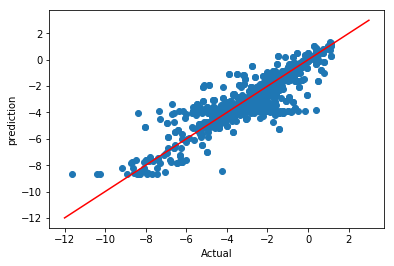

-1.1373096457974903


In [57]:
p,ax = plt.subplots()
ax.scatter(YtoTrain[1500:],predictions)
ax.plot([-12,3],[-12,3],color='red')
ax.set(xlabel='Actual', ylabel='prediction')
plt.show()
accuracy = metrics.r2_score(Y128[1500:], predictions)
print(accuracy)

-1.660801585862107


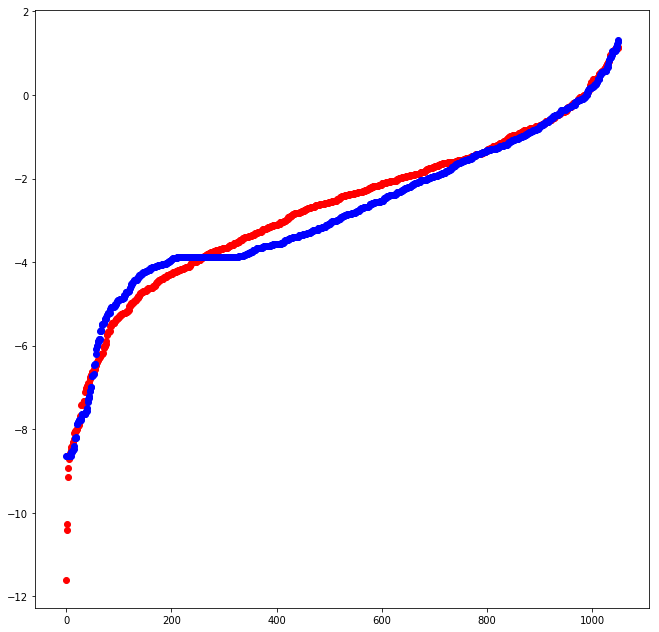

In [95]:
vals = []
for i in predictions:
    vals.append(i[0])
fig = plt.figure(figsize=(11,11))
X__ = np.sort(vals)
Y__ = np.sort(YtoTrain[1500:])
plt.scatter(range(len(Y128[1500:])),Y__,color='red')

plt.scatter(range(len(Y128[1500:])),X__,color='blue')
accuracy = metrics.r2_score(Y__,Y128[1500:])
print(accuracy)

r^2 value = 0.7873973856645755


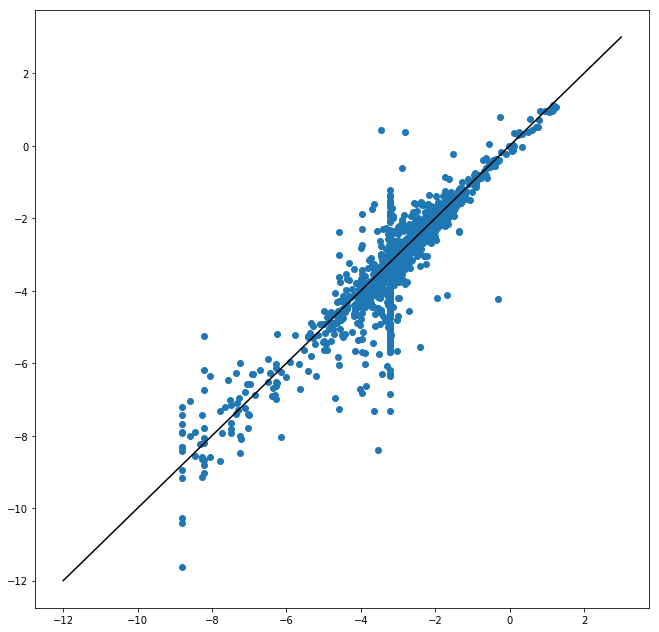

In [100]:
# i want to investigate if a model with more hidden layers will be benificial
def deeper_model():
    model = Sequential()
    model.add(Dense((len(X128[0])+8), input_dim=len(X128[0]), kernel_initializer=init, activation='relu'))
    model.add(Dense(16, kernel_initializer=init, activation='relu'))
    model.add(Dense(16, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model_D = deeper_model()
model_D.fit(np.array(X128[:1500]),np.array(Y128[:1500]),batch_size=batch_size,epochs=epochs,verbose=0)
preds_D = model_D.predict(np.array(X128[1500:]))

fig = plt.figure(figsize=(11,11))
plt.scatter(preds_D,Y128[1500:])
accuracy = metrics.r2_score(preds_D,Y128[1500:])
plt.plot([-12,3],[-12,3],color='black')

print(f"r^2 value = {accuracy}")

r^2 value = 0.8004374994395704


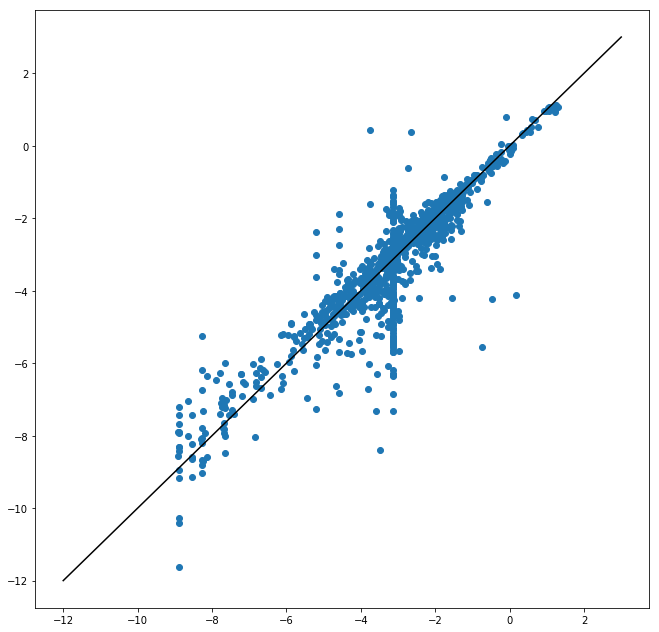

In [102]:
# i want to investigate if a model with more hidden layers will be benificial
def deeper_model_32():
    model = Sequential()
    model.add(Dense((len(X128[0])+8), input_dim=len(X128[0]), kernel_initializer=init, activation='relu'))
    model.add(Dense(32, kernel_initializer=init, activation='relu'))
    model.add(Dense(32, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model_D_32 = deeper_model_32()
model_D_32.fit(np.array(X128[:1500]),np.array(Y128[:1500]),batch_size=batch_size,epochs=epochs,verbose=0)
preds_D_32 = model_D_32.predict(np.array(X128[1500:]))

fig = plt.figure(figsize=(11,11))
plt.scatter(preds_D_32,Y128[1500:])
accuracy = metrics.r2_score(preds_D_32,Y128[1500:])
plt.plot([-12,3],[-12,3],color='black')

print(f"r^2 value = {accuracy}")

r^2 value = 0.9384813136094461


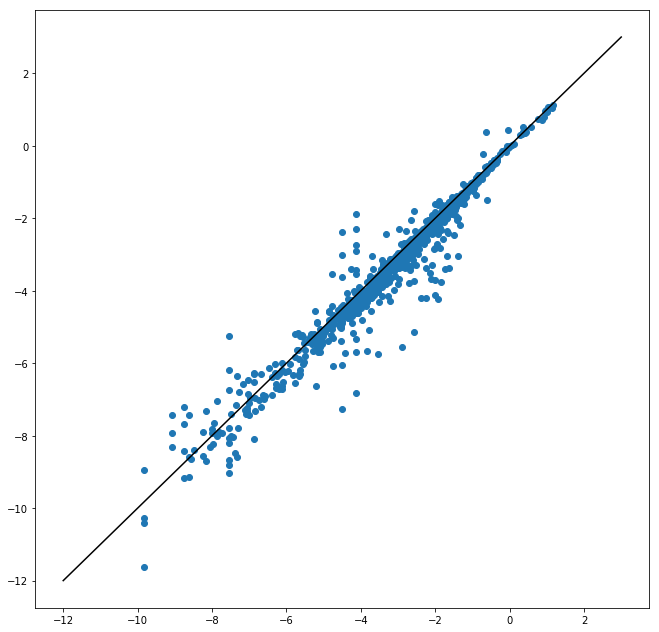

In [106]:
#fp size increased to 2048
def deeper_model_32_dim2048():
    model = Sequential()
    model.add(Dense((len(X2048[0])+8), input_dim=len(X2048[0]), kernel_initializer=init, activation='relu'))
    model.add(Dense(32, kernel_initializer=init, activation='relu'))
    model.add(Dense(32, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model_D_32_dim2048 = deeper_model_32_dim2048()
model_D_32_dim2048.fit(np.array(X2048[:1500]),np.array(Y128[:1500]),batch_size=batch_size,epochs=epochs,verbose=0)
preds_D_32_dim2048 = model_D_32_dim2048.predict(np.array(X2048[1500:]))

fig = plt.figure(figsize=(11,11))
plt.scatter(preds_D_32_dim2048,Y128[1500:])
accuracy = metrics.r2_score(preds_D_32_dim2048,Y128[1500:])
plt.plot([-12,3],[-12,3],color='black')

print(f"r^2 value = {accuracy}")

r^2 value = 0.9498078550573343


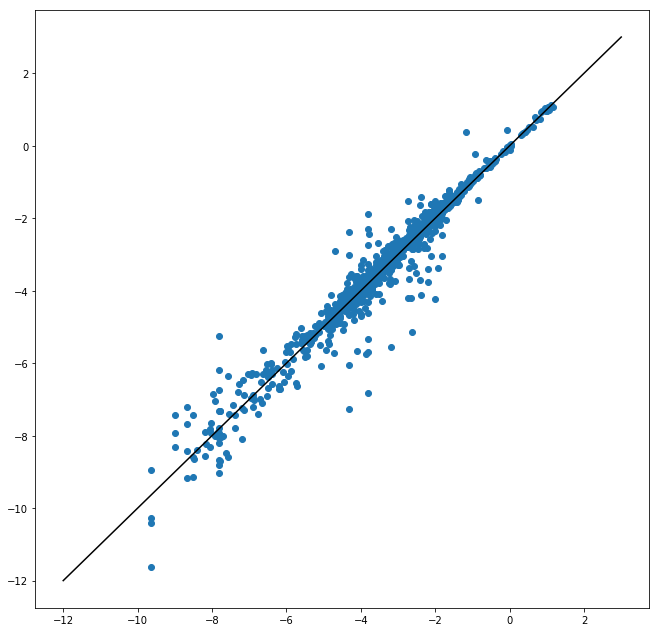

In [107]:
#fp size increased to 2048
def deeper_model_32_dim2048():
    model = Sequential()
    model.add(Dense((len(X2048[0])+8), input_dim=len(X2048[0]), kernel_initializer=init, activation='relu'))
    model.add(Dense(32, kernel_initializer=init, activation='relu'))
    model.add(Dense(32, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model_D_32_dim2048 = deeper_model_32_dim2048()
model_D_32_dim2048.fit(np.array(X2048[:1500]),np.array(Y128[:1500]),batch_size=batch_size,epochs=epochs,verbose=0)
preds_D_32_dim2048 = model_D_32_dim2048.predict(np.array(X2048[1500:]))

fig = plt.figure(figsize=(11,11))
plt.scatter(preds_D_32_dim2048,Y128[1500:])
accuracy = metrics.r2_score(preds_D_32_dim2048,Y128[1500:])
plt.plot([-12,3],[-12,3],color='black')

print(f"r^2 value = {accuracy}")

<p1>We observe a pretty good increase in r^2 value with the fingerpring increased to 2048</p1>

r^2 value = 0.9544735817870491


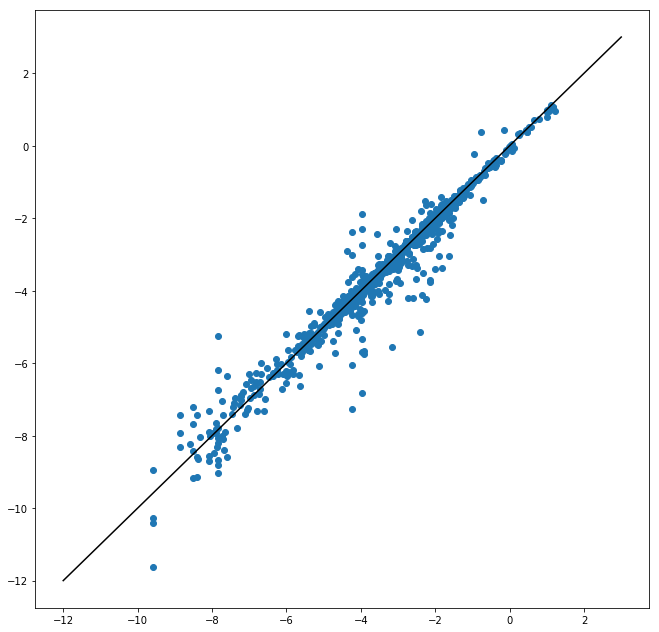

In [108]:
#fp size increased to 2048
def deeper_model_64_dim2048():
    model = Sequential()
    model.add(Dense((len(X2048[0])+8), input_dim=len(X2048[0]), kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model_D_64_dim2048 = deeper_model_32_dim2048()
model_D_64_dim2048.fit(np.array(X2048[:1500]),np.array(Y128[:1500]),batch_size=batch_size,epochs=epochs,verbose=0)
preds_D_64_dim2048 = model_D_64_dim2048.predict(np.array(X2048[1500:]))

fig = plt.figure(figsize=(11,11))
plt.scatter(preds_D_64_dim2048,Y128[1500:])
accuracy = metrics.r2_score(preds_D_64_dim2048,Y128[1500:])
plt.plot([-12,3],[-12,3],color='black')

print(f"r^2 value = {accuracy}")

r^2 value = 0.9430200880068834


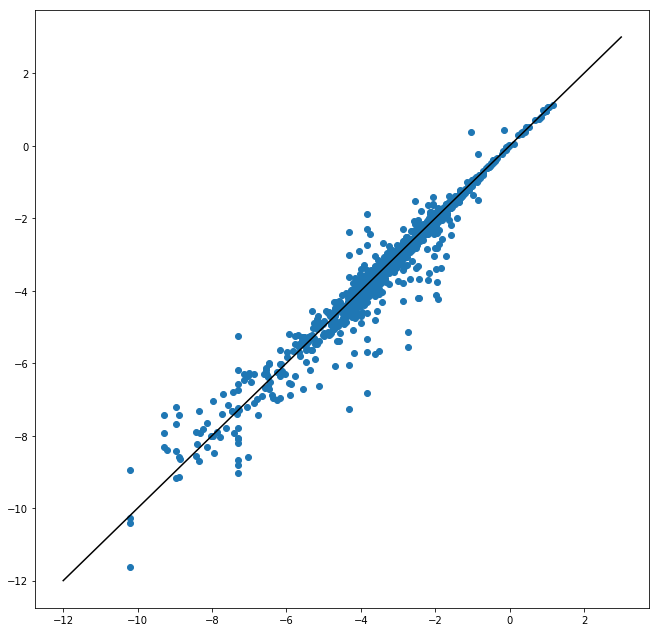

In [123]:
#fp size increased to 2048
def deeper_model_64_dim2048():
    model = Sequential()
    model.add(Dense((len(X2048[0])+8), input_dim=len(X2048[0]), kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model_D_64_dim2048 = deeper_model_32_dim2048()
model_D_64_dim2048.fit(np.array(X2048[:1500]),np.array(Y128[:1500]),batch_size=75,epochs=epochs,verbose=0)
preds_D_64_dim2048 = model_D_64_dim2048.predict(np.array(X2048[1500:]))

fig = plt.figure(figsize=(11,11))
plt.scatter(preds_D_64_dim2048,Y128[1500:])
accuracy = metrics.r2_score(preds_D_64_dim2048,Y128[1500:])
plt.plot([-12,3],[-12,3],color='black')

print(f"r^2 value = {accuracy}")

r^2 value = 0.9291326067493145


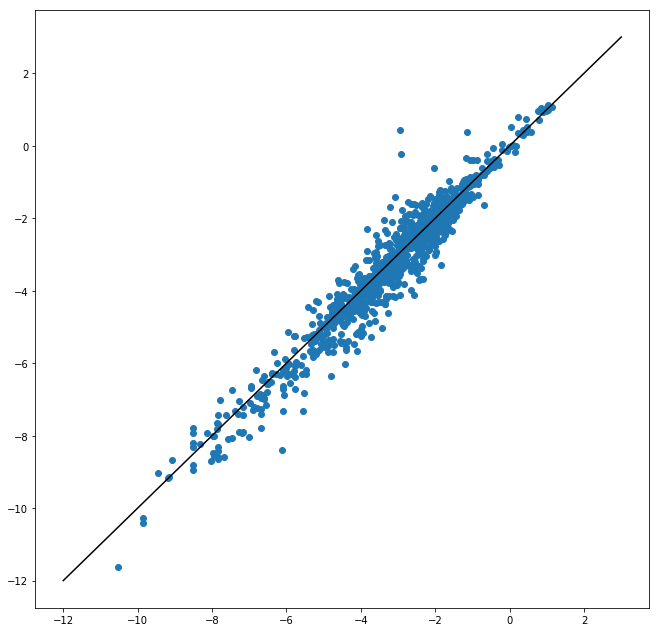

In [115]:
#fp size increased to 2048 and this will include the descriptors
def deeper_model_32_dim2048_F():
    model = Sequential()
    model.add(Dense((len(X2048True[0])+8), input_dim=len(X2048True[0]), kernel_initializer=init, activation='relu'))
    model.add(Dense(32, kernel_initializer=init, activation='relu'))
    model.add(Dense(32, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model_D_32_dim2048F = deeper_model_32_dim2048_F()
model_D_32_dim2048F.fit(np.array(X2048True[:1500]),np.array(Y128[:1500]),batch_size=batch_size,epochs=epochs,verbose=0)
preds_D_32_dim2048F = model_D_32_dim2048F.predict(np.array(X2048True[1500:]))

fig = plt.figure(figsize=(11,11))
plt.scatter(preds_D_32_dim2048F,Y128[1500:])
accuracy = metrics.r2_score(preds_D_32_dim2048F,Y128[1500:])
plt.plot([-12,3],[-12,3],color='black')
print(f"r^2 value = {accuracy}")
#plt.set(xlabel='Actual', ylabel='prediction')


In [ ]:
#doesnt look like including the descriptors helped in the above trial

r^2 value = 0.7346196320769145


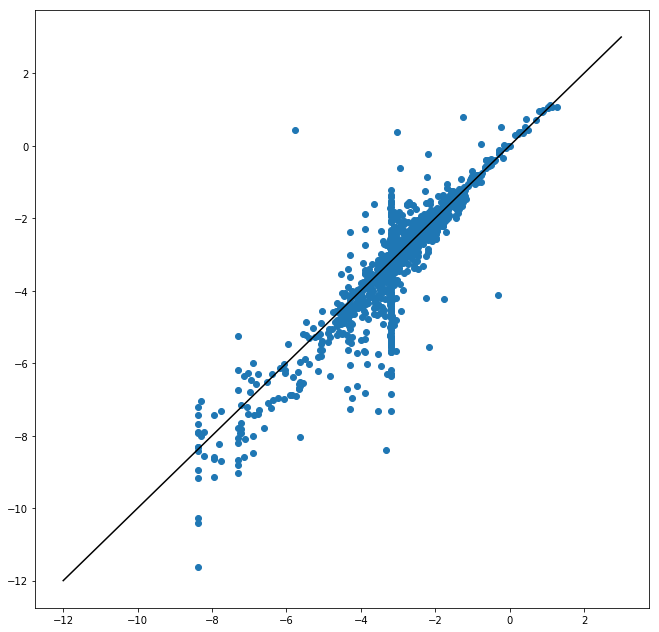

In [101]:
# i want to investigate if a model with more hidden layers will be benificial
def deeper_model_64():
    model = Sequential()
    model.add(Dense((len(X128[0])+8), input_dim=len(X128[0]), kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model_D_64 = deeper_model_64()
model_D_64.fit(np.array(X128[:1500]),np.array(Y128[:1500]),batch_size=batch_size,epochs=epochs,verbose=0)
preds_D_64 = model_D_64.predict(np.array(X128[1500:]))
fig = plt.figure(figsize=(11,11))
plt.scatter(preds_D_64,Y128[1500:])
accuracy = metrics.r2_score(preds_D_64,Y128[1500:])
plt.plot([-12,3],[-12,3],color='black')

print(f"r^2 value = {accuracy}")

r^2 value = 0.790751353610974


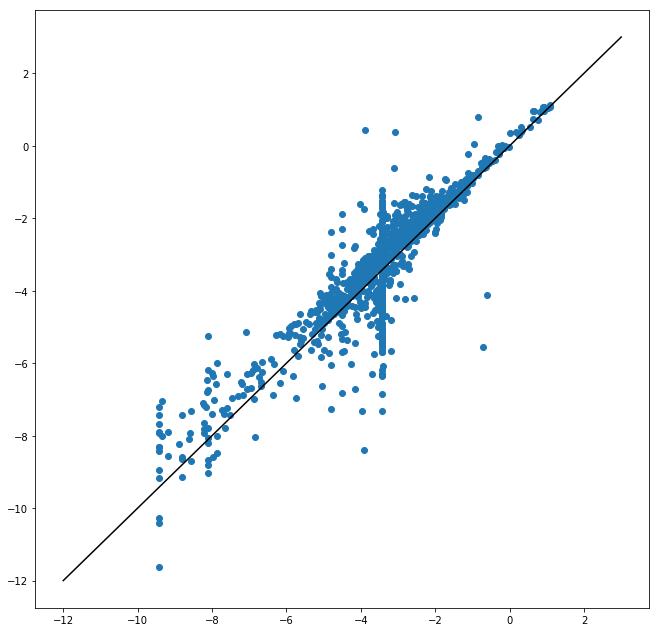

In [103]:
# i want to investigate if a model with more hidden layers will be benificial
def deeper_model_64_x3():
    model = Sequential()
    model.add(Dense((len(X128[0])+8), input_dim=len(X128[0]), kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model_D_64_x3 = deeper_model_64_x3()
model_D_64_x3.fit(np.array(X128[:1500]),np.array(Y128[:1500]),batch_size=batch_size,epochs=epochs,verbose=0)
preds_D_64_x3 = model_D_64_x3.predict(np.array(X128[1500:]))
fig = plt.figure(figsize=(11,11))
plt.scatter(preds_D_64_x3,Y128[1500:])
accuracy = metrics.r2_score(preds_D_64_x3,Y128[1500:])
plt.plot([-12,3],[-12,3],color='black')

print(f"r^2 value = {accuracy}")

r^2 value = 0.7491312188011829


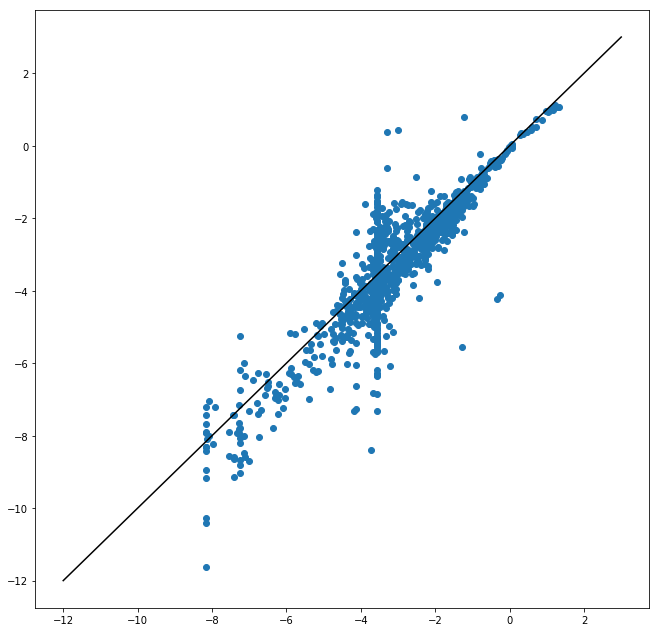

In [104]:
# i want to investigate if a model with more hidden layers will be benificial
def deeper_model_64_x4():
    model = Sequential()
    model.add(Dense((len(X128[0])+8), input_dim=len(X128[0]), kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model_D_64_x4 = deeper_model_64()
model_D_64_x4.fit(np.array(X128[:1500]),np.array(Y128[:1500]),batch_size=batch_size,epochs=epochs,verbose=0)
preds_D_64_x4 = model_D_64_x4.predict(np.array(X128[1500:]))
fig = plt.figure(figsize=(11,11))
plt.scatter(preds_D_64_x4,Y128[1500:])
accuracy = metrics.r2_score(preds_D_64_x4,Y128[1500:])
plt.plot([-12,3],[-12,3],color='black')

print(f"r^2 value = {accuracy}")

<h1>testing using scikit learn's neural network regressor</h1>

In [222]:
from sklearn.neural_network import MLPRegressor
sklearnNN = MLPRegressor(alpha=100,max_iter=8000, hidden_layer_sizes=[8,6], early_stopping=False)
sklearnNN.fit(X200[:1500],Y200[:1500])

MLPRegressor(activation='relu', alpha=100, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[8, 6], learning_rate='constant',
       learning_rate_init=0.001, max_iter=8000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [176]:
smiles_= ['C12=CC=CC(=C1C(C=C(C2=O)C)=O)O[H]']
XTest,YTest = get_fp(smiles_,preY,200,True)


In [223]:
pred = sklearnNN.predict(X200[1500:])


number of samples predicted : 1051


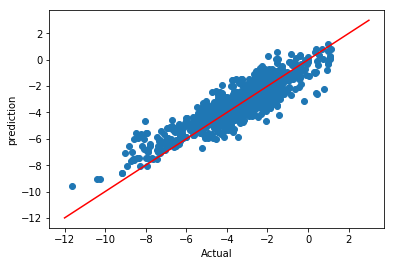

In [228]:
p,ax = plt.subplots()
ax.scatter(Y200[1500:],pred)
ax.plot([-12,3],[-12,3],color='red')
ax.set(xlabel='Actual', ylabel='prediction')
print(f"number of samples predicted : {len(Y200[1500:])}")